<a href="https://colab.research.google.com/github/SiMori92/Reddit_NQ_ML/blob/main/Keywords_time_series_binary_v3_(post_submit_revision).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem we solve:
- Correlation between Reddit comment and Stock market performance

Content

- Pre1: load library
- Pre2: load data
  - split training set & testing set
1. Data inspection
  1. meta features
2. Data processing
  1. clean the comments with stop words
  2. obtain list of top 200 words
  3. normalise
  4. Dictionary vectorize
3. Prepare the Training dataset
  1. check for Duplicated labeled records
  2. define labels and features
  3. create time-series variables
4. Training
  1. models
    - SVM
    - Gaussian Naive Bayes
    - Random Forest
    - XGBoost
    - KNN
    - Perceptron
    - Stochastic Gradient Descent (SGD)
5. Evaluation
  1. Accuracy
  2. F1
6. Analysis

In [ ]:
# import library

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import string

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Libraries for text preprocessing.
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.preprocessing import LabelEncoder

!pip install bert-tensorflow
from bert import tokenization

from wordcloud import STOPWORDS

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.2 MB/s eta 0:00:00


In [ ]:
#sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# #load excel

consol_df = pd.read_csv("/content/drive/MyDrive/CUSCS - Group project/Reddit_WhatAreYourMoveTmr/consol_Reddit_comment_Jan-Jun23.csv")
consol_df = consol_df.set_index('date')
consol_df = consol_df.drop(columns=['Unnamed: 0', 'index'])
consol_df


,comments,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,percent_chnage_x,Jump_x,Big_Jump_x,...,High_y,Low_y,Close_y,Adj Close_y,Volume_y,percent_chnage_y,Jump_y,Big_Jump_y,Drop_y,Big_Drop_y
date,,,,,,,,,,,,,,,,,,,,,
2022-07-13,This week's [Earnings Thread](https://www.redd...,3779.669922,3829.439941,3759.070068,3801.780029,3801.780029,4109390000,0.584975,1,0,...,11325.66992,11031.26953,11247.58008,11247.58008,4433060000,1.727757,0,1,0,0
2022-07-14,This week's [Earnings Thread](https://www.redd...,3763.989990,3796.409912,3721.560059,3790.379883,3790.379883,4199690000,0.701115,1,0,...,11279.96973,11005.92969,11251.19043,11251.19043,4481070000,0.896589,1,0,0,0
2022-07-15,Cashed out up 56k today. Now cuddled up watchi...,3818.000000,3863.620117,3817.179932,3863.159912,3863.159912,4143800000,1.182816,0,1,...,11454.69043,11295.33008,11452.41992,11452.41992,4369060000,0.642036,1,0,0,0
2022-07-19,This week's [Earnings Thread](https://www.redd...,3860.729980,3939.810059,3860.729980,3936.689941,3936.689941,4041070000,1.967503,0,1,...,11721.21973,11448.96973,11713.15039,11713.15039,5302740000,1.720802,0,1,0,0
2022-07-20,If 2008 was the Great Recession\n\nThen 2022 i...,3935.320068,3974.129883,3922.030029,3959.899902,3959.899902,4185300000,0.624596,1,0,...,11939.95996,11703.36035,11897.65039,11897.65039,5467080000,1.463067,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,I was holding puts over the weekend. Thought f...,4344.839844,4362.060059,4328.080078,4328.819824,4328.819824,3415030000,-0.368714,0,0,...,13573.57031,13334.41992,13335.78027,13335.78027,4430600000,-0.987174,0,0,1,0
2023-06-27,I watched TSLA rise for 3 months. 3 months. 3 ...,4337.359863,4384.419922,4335.000000,4378.410156,4378.410156,3573500000,0.946435,1,0,...,13578.79980,13366.96973,13555.66992,13555.66992,5053660000,1.242937,0,1,0,0
2023-06-28,Trades when I 15x: $300 invested\n\nTrades whe...,4367.479980,4390.350098,4360.220215,4376.859863,4376.859863,3739330000,0.214766,1,0,...,13654.13965,13495.73047,13591.75000,13591.75000,4533270000,0.634757,1,0,0,0


In [ ]:
column_names = consol_df.columns.tolist()

print(column_names)

consol_df = consol_df.rename(columns={'Volume_x': 'Volume_SP500','Jump_x':'Jump_SP500','Big_Jump_x':'Big_Jump_SP500','Drop_x':'Drop_SP500','Big_Drop_x':'Big_Drop_SP500',
                      'Volume_y': 'Volume_NQ','Jump_y':'Jump_NQ','Big_Jump_y':'Big_Jump_NQ','Drop_y':'Drop_NQ','Big_Drop_y':'Big_Drop_NQ'})

['comments', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Adj Close_x', 'Volume_x', 'percent_chnage_x', 'Jump_x', 'Big_Jump_x', 'Drop_x', 'Big_Drop_x', 'Open_y', 'High_y', 'Low_y', 'Close_y', 'Adj Close_y', 'Volume_y', 'percent_chnage_y', 'Jump_y', 'Big_Jump_y', 'Drop_y', 'Big_Drop_y']


In [ ]:
# split training set & testing set

train_df = consol_df[10:111]

test_df = pd.concat([consol_df.iloc[0:10], consol_df.iloc[111:]]).reset_index()

train_df

,comments,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_SP500,percent_chnage_x,Jump_SP500,Big_Jump_SP500,...,High_y,Low_y,Close_y,Adj Close_y,Volume_NQ,percent_chnage_y,Jump_NQ,Big_Jump_NQ,Drop_NQ,Big_Drop_NQ
date,,,,,,,,,,,,,,,,,,,,,
2023-01-18,#Ban Bet Lost\n\n/u/TeslaLeafBlower made a bet...,4002.250000,4014.159912,3926.590088,3928.860107,3928.860107,4298710000,-1.833716,0,0,...,11223.41016,10952.04980,10957.00977,10957.00977,5288630000,-1.915150,0,0,0,1
2023-01-19,Got burnt buying PUTs for two weeks straight. ...,3911.840088,3922.939941,3885.540039,3898.850098,3898.850098,3991500000,-0.332069,0,0,...,10932.51953,10804.57031,10852.26953,10852.26953,4660800000,-0.350133,0,0,1,0
2023-01-20,Netflix misses and the CEO quits and the stock...,3909.040039,3972.959961,3897.860107,3972.610107,3972.610107,4013360000,1.626232,0,1,...,11143.16992,10885.65039,11140.42969,11140.42969,5980110000,1.975069,0,1,0,0
2023-01-23,I’m getting so old that the moms in commercial...,3978.139893,4039.310059,3971.639893,4019.810059,4019.810059,3945210000,1.047479,0,1,...,11405.50000,11144.03027,11364.41016,11364.41016,5997810000,1.722796,0,1,0,0
2023-01-24,After 3 months straight of losing 50% of my po...,4001.739990,4023.919922,3989.790039,4016.949951,4016.949951,3320430000,0.380084,1,0,...,11378.15039,11282.65039,11334.26953,11334.26953,5670860000,0.277272,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,"If anyone wants a good value stock, AAPL is tr...",4352.609863,4375.370117,4349.310059,4369.009766,4369.009766,4275400000,0.376783,1,0,...,13594.40039,13473.19043,13573.32031,13573.32031,5522100000,0.050050,1,0,0,0
2023-06-14,I’m up 13% in Carvana and 15% in Adobe. Too b...,4366.290039,4391.819824,4337.850098,4372.589844,4372.589844,4252110000,0.144283,1,0,...,13661.74023,13455.99023,13626.48047,13626.48047,5772550000,0.412075,1,0,0,0
2023-06-15,SPY historical average annual returns: 9%\n \...,4365.330078,4439.200195,4362.600098,4425.839844,4425.839844,4176690000,1.386144,0,1,...,13828.16992,13561.37012,13782.82031,13782.82031,5667520000,1.546764,0,1,0,0


## 1. Data inspection

In [ ]:
# 2. Meta Features (understand the structure between training & test dataset)

# word_count
train_df['word_count'] = train_df['comments'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['comments'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df['unique_word_count'] = train_df['comments'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['comments'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_df['stop_word_count'] = train_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_df['url_count'] = train_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df['mean_word_length'] = train_df['comments'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['comments'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['comments'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['comments'].apply(lambda x: len(str(x)))

# punctuation_count
train_df['punctuation_count'] = train_df['comments'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['comments'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df['hashtag_count'] = train_df['comments'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['comments'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_df['mention_count'] = train_df['comments'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['comments'].apply(lambda x: len([c for c in str(x) if c == '@']))


<ipython-input-10-790355bac8b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['word_count'] = train_df['comments'].apply(lambda x: len(str(x).split()))
<ipython-input-10-790355bac8b2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['unique_word_count'] = train_df['comments'].apply(lambda x: len(set(str(x).split())))
<ipython-input-10-790355bac8b2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [ ]:
train_df.describe()

,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_SP500,percent_chnage_x,Jump_SP500,Big_Jump_SP500,Drop_SP500,...,Big_Drop_NQ,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
count,101.000000,101.000000,101.000000,101.000000,101.000000,1.010000e+02,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,1.010000e+02,101.000000,101.000000,101.000000
mean,4095.803962,4121.131495,4073.600898,4100.630601,4100.630601,4.223087e+09,0.119000,0.376238,0.138614,0.396040,...,0.108911,87281.118812,16786.712871,35340.049505,173.960396,4.921620,5.186320e+05,28412.217822,168.376238,55.712871
std,116.494424,113.781575,120.731608,119.546284,119.546284,8.263298e+08,0.800491,0.486857,0.347267,0.491512,...,0.313081,26297.164757,2725.151582,10625.417845,105.853760,0.083056,1.560895e+05,8376.039500,50.230240,21.043449
min,3835.120117,3905.050049,3808.860107,3855.760010,3855.760010,3.290940e+09,-2.009169,0.000000,0.000000,0.000000,...,0.000000,45545.000000,11572.000000,18206.000000,38.000000,4.782365,2.730640e+05,16356.000000,83.000000,3.000000
25%,4001.830078,4030.590088,3976.899902,4012.320068,4012.320068,3.772080e+09,-0.289474,0.000000,0.000000,0.000000,...,0.000000,72122.000000,15169.000000,28842.000000,118.000000,4.875486,4.304060e+05,23405.000000,133.000000,46.000000
50%,4105.350098,4132.959961,4088.389893,4109.899902,4109.899902,4.041900e+09,0.027560,0.000000,0.000000,0.000000,...,0.000000,82430.000000,16513.000000,33701.000000,139.000000,4.918733,4.847120e+05,26681.000000,169.000000,55.000000
75%,4140.109863,4165.740234,4123.810059,4151.319824,4151.319824,4.298710e+09,0.682124,1.000000,0.000000,1.000000,...,0.000000,93903.000000,17820.000000,38311.000000,164.000000,4.963044,5.661950e+05,31662.000000,194.000000,66.000000
max,4440.950195,4448.470215,4407.439941,4425.839844,4425.839844,9.354280e+09,2.097230,1.000000,1.000000,1.000000,...,1.000000,204371.000000,26663.000000,82978.000000,562.000000,5.303534,1.213525e+06,60917.000000,355.000000,128.000000


In [ ]:
test_df.describe()

,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_SP500,percent_chnage_x,Jump_SP500,Big_Jump_SP500,Drop_SP500,...,Big_Drop_NQ,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
count,18.000000,18.000000,18.000000,18.000000,18.000000,1.800000e+01,18.000000,18.000000,18.000000,18.000000,...,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,4108.128825,4143.247233,4093.212226,4131.200534,4131.200534,4.017024e+09,0.578570,0.500000,0.277778,0.222222,...,0.055556,102213.055556,18154.111111,41888.777778,140.166667,4.806944,592942.833333,29244.166667,134.555556,52.444444
std,247.557576,238.188044,253.599776,238.267744,238.267744,5.826001e+08,0.736146,0.514496,0.460889,0.427793,...,0.235702,33814.059012,3990.028850,13832.930728,75.219092,0.100623,189742.425995,7510.252422,42.265578,44.545050
min,3763.989990,3796.409912,3721.560059,3790.379883,3790.379883,3.415030e+09,-0.813765,0.000000,0.000000,0.000000,...,0.000000,46969.000000,11196.000000,19042.000000,44.000000,4.690544,283771.000000,16904.000000,72.000000,4.000000
25%,3939.347534,3958.447449,3913.562500,3942.492431,3942.492431,3.699828e+09,0.074875,0.000000,0.000000,0.000000,...,0.000000,72100.000000,14637.500000,29622.250000,64.750000,4.739341,423560.500000,23903.250000,94.750000,6.000000
50%,3995.924927,4059.255005,3972.199951,4048.020019,4048.020019,3.982260e+09,0.616406,0.500000,0.000000,0.000000,...,0.000000,108248.500000,19736.000000,44872.500000,162.000000,4.762964,621521.500000,29078.000000,136.000000,63.500000
75%,4355.092407,4383.877441,4349.199829,4374.067382,4374.067382,4.141048e+09,1.061036,1.000000,0.750000,0.000000,...,0.000000,134584.000000,21845.000000,54865.750000,202.750000,4.898930,772918.750000,35955.500000,163.500000,91.000000
max,4422.439941,4458.479980,4422.439941,4450.379883,4450.379883,6.053620e+09,1.967503,1.000000,1.000000,1.000000,...,1.000000,140046.000000,22343.000000,58161.000000,254.000000,5.021993,811301.000000,39267.000000,222.000000,111.000000


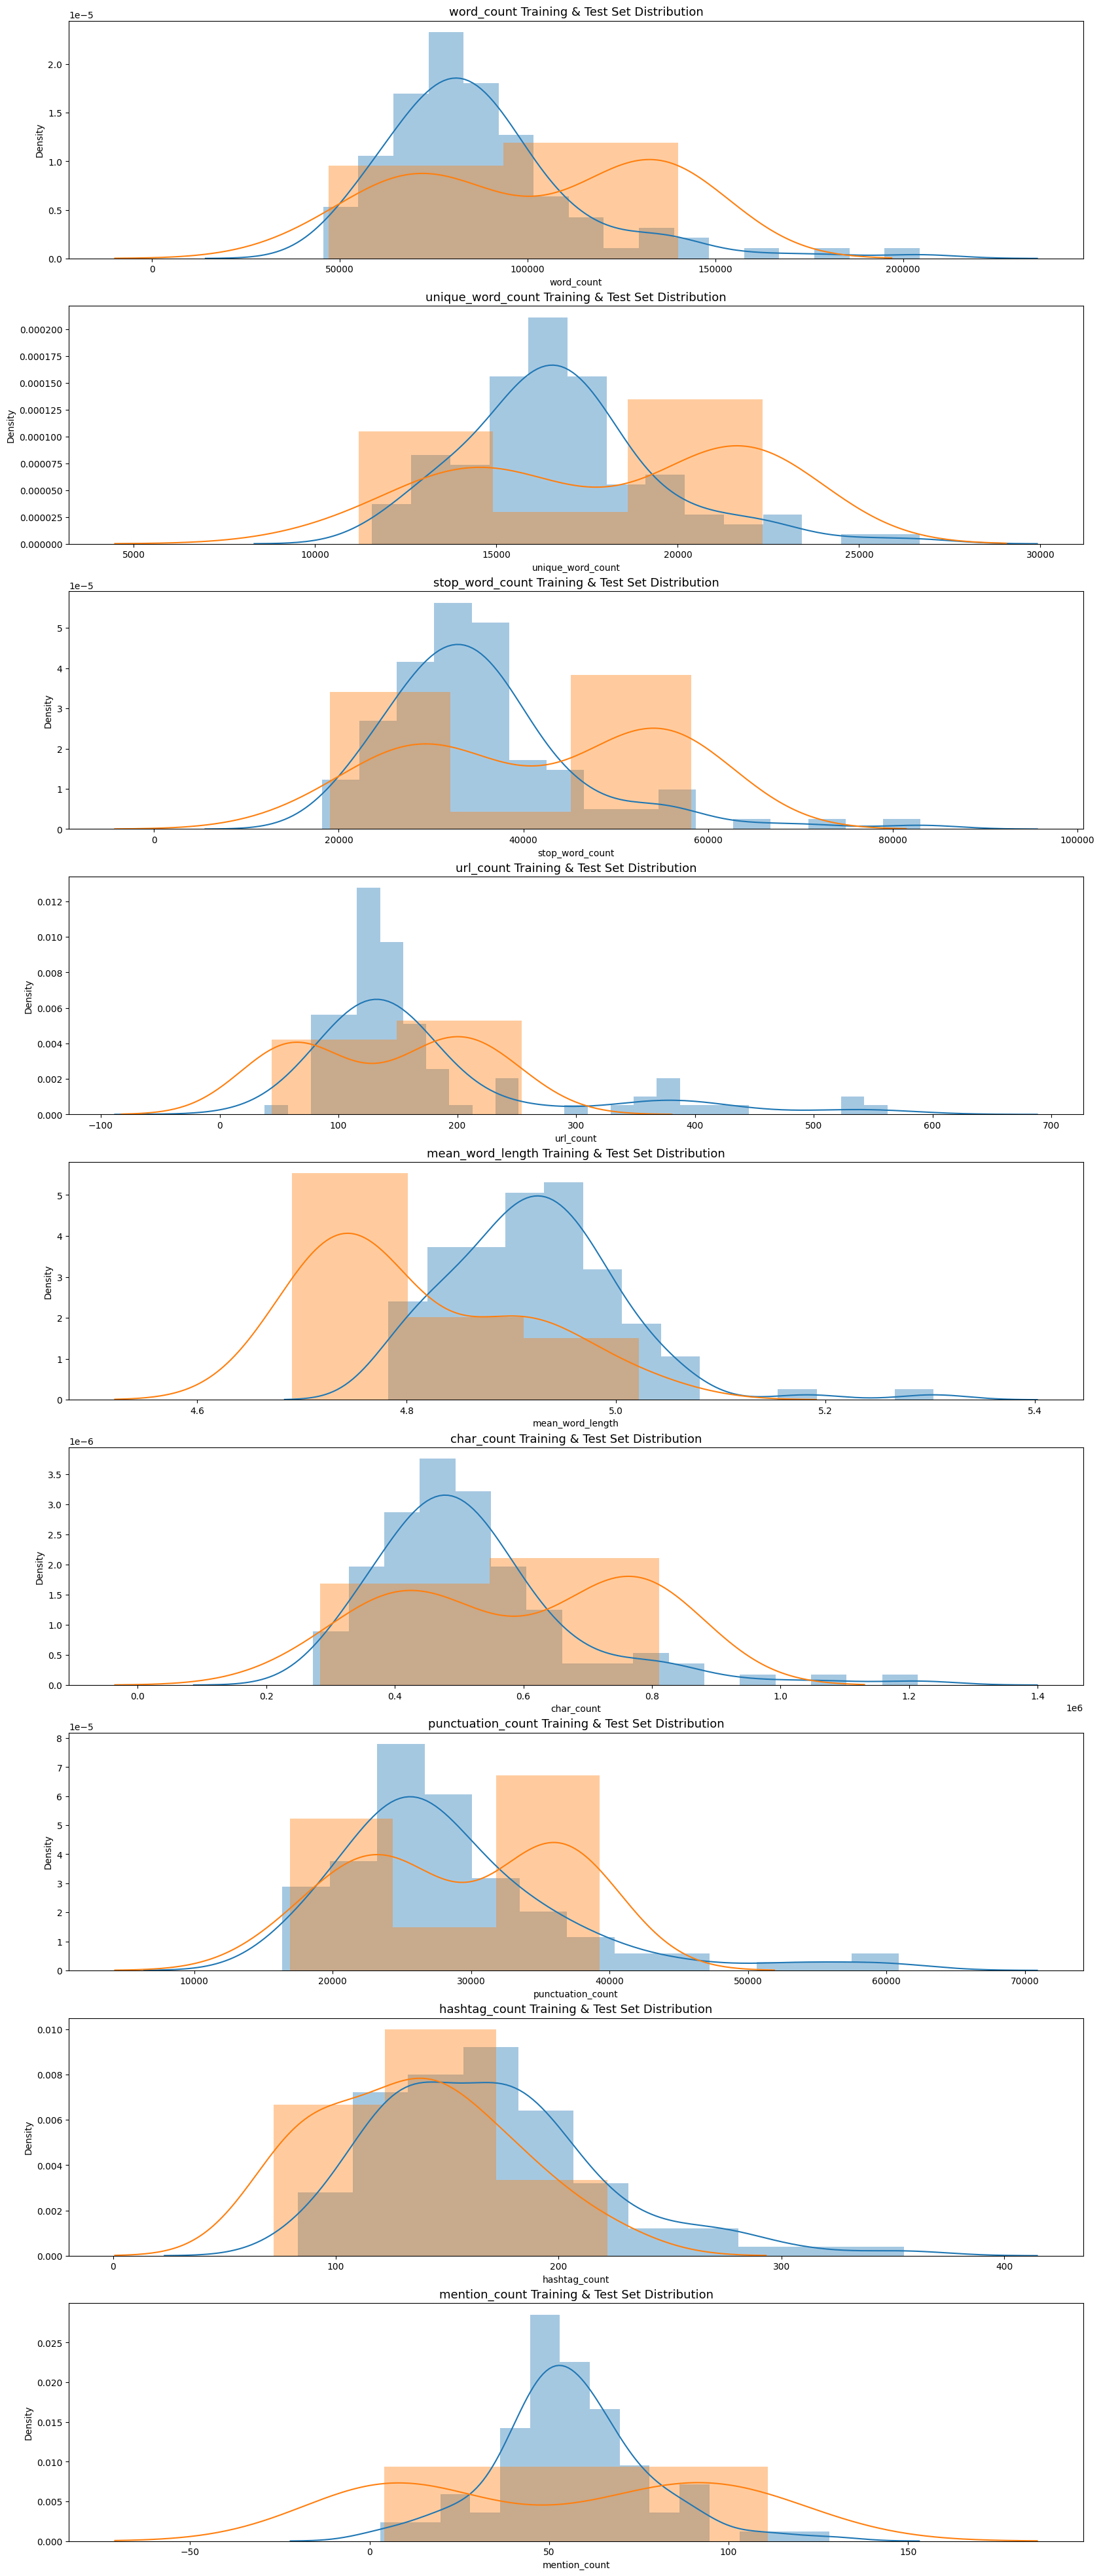

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# visualisation of meta features

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):

    sns.distplot(train_df[feature], label='Training', ax=axes[i])
    sns.distplot(test_df[feature], label='Test', ax=axes[i])

    axes[i].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

##2. Data processing

In [ ]:
# clear by stop words
# NLTK - stop words

nltk.download('stopwords')

from nltk.corpus import stopwords
print(stopwords.words('english'))
len(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


179

In [ ]:
# Wordcloud
print(STOPWORDS)
len(STOPWORDS)

{"can't", "shan't", 'their', 'should', 'both', 'for', 'be', "don't", 'had', 'themselves', "won't", 'could', "wasn't", 'yours', "hadn't", 'however', 'to', 'yourselves', 'would', 'ours', 'or', 'such', 'else', 'against', 'otherwise', 'and', "i'm", 'having', 'by', 'it', 'nor', "it's", "wouldn't", "you'll", 'this', "we're", 'same', "we've", "they'll", 'http', 'herself', 'from', 'down', 'that', 'being', "we'll", 'why', 'can', 'therefore', 'my', 'each', 'of', 'himself', 'have', 'out', "who's", 'before', "he'll", 'hers', "that's", 'there', "you'd", 'so', 'shall', 'www', 'all', 'a', "didn't", 'its', 'own', 'theirs', 'not', 'ever', "how's", 'itself', 'what', 'him', "let's", 'most', 'then', 'com', 'has', 'at', 'no', 'again', "there's", 'our', 'since', 'until', 'if', 'some', 'with', 'under', 'are', 'get', 'while', 'other', "shouldn't", 'myself', "mustn't", 'her', 'above', 'these', 'how', 'when', 'them', 'doing', 'but', 'the', "weren't", 'she', "isn't", 'did', 'just', 'up', 'over', 'your', "i'll", 

192

In [ ]:
# SK learn - ENGLISH_STOP_WORDS

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(ENGLISH_STOP_WORDS)
len(ENGLISH_STOP_WORDS)

frozenset({'except', 'last', 'move', 'nothing', 'for', 'everyone', 'nevertheless', 'fifteen', 'had', 'yours', 'to', 'would', 'whole', 'or', 'whoever', 'someone', 'noone', 'beforehand', 'cant', 'please', 'and', 'sometimes', 'by', 'none', 'nor', 'always', 'being', 'perhaps', 'cry', 'why', 'next', 'either', 'my', 'eleven', 'whose', 'himself', 'before', 'mill', 'so', 'two', 'own', 'not', 'namely', 'itself', 'within', 'him', 'formerly', 'seeming', 'some', 'meanwhile', 'seems', 'other', 'these', 'her', 'side', 'twenty', 'the', 'becomes', 'moreover', 'many', 'per', 'will', 'give', 'very', 'i', 'well', 'never', 'fifty', 'con', 'de', 'must', 'whereafter', 'is', 'into', 'whence', 'he', 'twelve', 'through', 'top', 'anyone', 'already', 'show', 'am', 'they', 're', 'me', 'becoming', 'hereby', 'also', 'inc', 'see', 'ourselves', 'hereafter', 'once', 'less', 'those', 'another', 'couldnt', 'ltd', 'their', 'be', 'could', 'amoungst', 'however', 'latter', 'sometime', 'such', 'whatever', 'same', 'anything',

318

In [ ]:
# create sets of stop words

nltk_stop_words = set(stopwords.words('english'))
wordcloud_stop_words = set(STOPWORDS)
sklearn_stop_words = set(ENGLISH_STOP_WORDS)

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "`"
    for p in punctuations:
        text = text.replace(p, ' ')

    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in nltk_stop_words])
    text = ' '.join([word for word in text.split() if word not in wordcloud_stop_words])
    text = ' '.join([word for word in text.split() if word not in wordcloud_stop_words])

    return text

In [ ]:
# clean the text with stop words

train_df['cleaned_comments'] = train_df['comments'].apply(clean_text)

test_df['cleaned_comments'] = test_df['comments'].apply(clean_text)

In [ ]:
# rank the word distribution frequency of full year data
# tokenise
# extarct the top 200 words

from collections import Counter

# Load the raw text column into a Python list
text_list = train_df['cleaned_comments'] .tolist()

# Tokenize the text using the nltk library
tokens = [nltk.word_tokenize(text) for text in text_list]

# Flatten the list of tokens into a single list
flat_tokens = [item for sublist in tokens for item in sublist]

# Count the frequency of each word using the Counter function from the collections library
word_freq = Counter(flat_tokens)

# Filter the Counter object to only show the top 200 words
top_words = word_freq.most_common(200)

# Convert the filtered Counter object into a DataFrame
word_freq_df = pd.DataFrame(top_words, columns=['word', 'frequency'])

# Add a new column to the DataFrame with the rank of each word
word_freq_df['rank'] = word_freq_df['frequency'].rank(ascending=False)


In [ ]:
word_freq_df.to_csv('word_freq_df.csv')

In [ ]:
# 2nd round cleaned

def clean_second(comment):

    # Contractions
    comment = re.sub(r"he's", "he is", comment)
    comment = re.sub(r"there's", "there is", comment)
    comment = re.sub(r"We're", "We are", comment)
    comment = re.sub(r"That's", "That is", comment)
    comment = re.sub(r"won't", "will not", comment)
    comment = re.sub(r"they're", "they are", comment)
    comment = re.sub(r"Can't", "Cannot", comment)
    comment = re.sub(r"wasn't", "was not", comment)
    comment = re.sub(r"don\x89Ûªt", "do not", comment)
    comment = re.sub(r"aren't", "are not", comment)
    comment = re.sub(r"isn't", "is not", comment)
    comment = re.sub(r"What's", "What is", comment)
    comment = re.sub(r"haven't", "have not", comment)
    comment = re.sub(r"hasn't", "has not", comment)
    comment = re.sub(r"There's", "There is", comment)
    comment = re.sub(r"He's", "He is", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"You're", "You are", comment)
    comment = re.sub(r"I'M", "I am", comment)
    comment = re.sub(r"shouldn't", "should not", comment)
    comment = re.sub(r"wouldn't", "would not", comment)
    comment = re.sub(r"i'm", "I am", comment)
    comment = re.sub(r"I\x89Ûªm", "I am", comment)
    comment = re.sub(r"I'm", "I am", comment)
    comment = re.sub(r"Isn't", "is not", comment)
    comment = re.sub(r"Here's", "Here is", comment)
    comment = re.sub(r"you've", "you have", comment)
    comment = re.sub(r"you\x89Ûªve", "you have", comment)
    comment = re.sub(r"we're", "we are", comment)
    comment = re.sub(r"what's", "what is", comment)
    comment = re.sub(r"couldn't", "could not", comment)
    comment = re.sub(r"we've", "we have", comment)
    comment = re.sub(r"it\x89Ûªs", "it is", comment)
    comment = re.sub(r"doesn\x89Ûªt", "does not", comment)
    comment = re.sub(r"It\x89Ûªs", "It is", comment)
    comment = re.sub(r"Here\x89Ûªs", "Here is", comment)
    comment = re.sub(r"who's", "who is", comment)
    comment = re.sub(r"I\x89Ûªve", "I have", comment)
    comment = re.sub(r"y'all", "you all", comment)
    comment = re.sub(r"can\x89Ûªt", "cannot", comment)
    comment = re.sub(r"would've", "would have", comment)
    comment = re.sub(r"it'll", "it will", comment)
    comment = re.sub(r"we'll", "we will", comment)
    comment = re.sub(r"wouldn\x89Ûªt", "would not", comment)
    comment = re.sub(r"We've", "We have", comment)
    comment = re.sub(r"he'll", "he will", comment)
    comment = re.sub(r"Y'all", "You all", comment)
    comment = re.sub(r"Weren't", "Were not", comment)
    comment = re.sub(r"Didn't", "Did not", comment)
    comment = re.sub(r"they'll", "they will", comment)
    comment = re.sub(r"they'd", "they would", comment)
    comment = re.sub(r"DON'T", "DO NOT", comment)
    comment = re.sub(r"That\x89Ûªs", "That is", comment)
    comment = re.sub(r"they've", "they have", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"should've", "should have", comment)
    comment = re.sub(r"You\x89Ûªre", "You are", comment)
    comment = re.sub(r"where's", "where is", comment)
    comment = re.sub(r"Don\x89Ûªt", "Do not", comment)
    comment = re.sub(r"we'd", "we would", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"weren't", "were not", comment)
    comment = re.sub(r"They're", "They are", comment)
    comment = re.sub(r"Can\x89Ûªt", "Cannot", comment)
    comment = re.sub(r"you\x89Ûªll", "you will", comment)
    comment = re.sub(r"I\x89Ûªd", "I would", comment)
    comment = re.sub(r"let's", "let us", comment)
    comment = re.sub(r"it's", "it is", comment)
    comment = re.sub(r"can't", "cannot", comment)
    comment = re.sub(r"don't", "do not", comment)
    comment = re.sub(r"you're", "you are", comment)
    comment = re.sub(r"i've", "I have", comment)
    comment = re.sub(r"that's", "that is", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"doesn't", "does not", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"didn't", "did not", comment)
    comment = re.sub(r"ain't", "am not", comment)
    comment = re.sub(r"you'll", "you will", comment)
    comment = re.sub(r"I've", "I have", comment)
    comment = re.sub(r"Don't", "do not", comment)
    comment = re.sub(r"I'll", "I will", comment)
    comment = re.sub(r"I'd", "I would", comment)
    comment = re.sub(r"Let's", "Let us", comment)
    comment = re.sub(r"you'd", "You would", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"Ain't", "am not", comment)
    comment = re.sub(r"Haven't", "Have not", comment)
    comment = re.sub(r"Could've", "Could have", comment)
    comment = re.sub(r"youve", "you have", comment)
    comment = re.sub(r"donå«t", "do not", comment)

    # customise
    comment = re.sub(r"emote", " ", comment)
    comment = re.sub(r"img", " ", comment)
    comment = re.sub(r"that", " ", comment)

    return comment

train_df['cleaned_comments_second'] = train_df['cleaned_comments'].apply(lambda s : clean_second(s))

test_df['cleaned_comments_second'] = test_df['cleaned_comments'].apply(lambda s : clean_second(s))


In [ ]:
# rank after 2nd round cleaned

# Load the raw text column into a Python list
text_list_second = train_df['cleaned_comments_second'] .tolist()

# Tokenize the text using the nltk library
tokens_second = [nltk.word_tokenize(text) for text in text_list_second]

# Flatten the list of tokens into a single list
flat_tokens_second = [item for sublist in tokens_second for item in sublist]

# Count the frequency of each word using the Counter function from the collections library
word_freq_second = Counter(flat_tokens_second)

# Filter the Counter object to only show the top 200 words
top_words_second = word_freq_second.most_common(200)

# Convert the filtered Counter object into a DataFrame
word_freq_df_second = pd.DataFrame(top_words_second, columns=['word', 'frequency'])

# Add a new column to the DataFrame with the rank of each word
word_freq_df_second['rank'] = word_freq_df_second['frequency'].rank(ascending=False)

In [ ]:
word_freq_df_second.to_csv('word_freq_df_second.csv')

In [ ]:
# Dictionary vectorise
from sklearn.feature_extraction import DictVectorizer

In [ ]:
# Dictionary vectorise

data_dict = [
    {"Red": 2, "Blue": 4},
    {"Red": 4, "Blue": 3},
    {"Red": 1, "Yellow": 2},
    {"Red": 2, "Yellow": 2}
]

# create dictionary vectorizer
dictvectorizer = DictVectorizer(sparse=False)

# convert dictionary to feature matrix
features = dictvectorizer.fit_transform(data_dict)

print(features)

# get feature names
feature_names = dictvectorizer.get_feature_names()
print(feature_names)

## 3. Prepare the Training dataset

In [ ]:
list_top200 = word_freq_df_second['word']
type(list_top200)

pandas.core.series.Series

In [ ]:
list_top200.to_csv('list_top200.csv')

In [ ]:
# create a training df

df_freq_train = pd.DataFrame(columns=list_top200, index=train_df.index)
for i, row in train_df.iterrows():
    for word in list_top200:
        count = row['cleaned_comments_second'].count(word)
        df_freq_train.at[i, word] = count
df_freq_train

word,",",t5_2th52,’,s,t,4271,i,market,it,go,...,end,pump,hope,nice,ban,wait,company,trading,month,tell
date,,,,,,,,,,,,,,,,,,,,,
2023-01-18,2001,1320,1257,18989,22748,241,17133,239,1994,1349,...,312,74,64,66,344,44,31,43,82,110
2023-01-19,2016,1471,1402,19626,23697,234,17555,268,2026,1377,...,312,51,78,70,324,83,46,46,100,86
2023-01-20,1965,1445,1349,20394,24174,196,18074,234,1956,1352,...,293,78,62,52,313,72,64,40,85,80
2023-01-23,1314,922,923,13862,16100,137,12417,170,1347,999,...,273,42,49,51,173,54,18,27,60,66
2023-01-24,2139,1292,1431,20446,24039,243,18090,355,2064,1280,...,305,56,67,74,325,76,41,47,95,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,2047,1435,1362,18542,22364,264,17162,416,1944,1232,...,264,92,73,39,171,60,40,62,130,69
2023-06-14,1964,1657,1264,18177,22347,310,16862,295,1682,1283,...,282,69,74,67,118,64,39,43,106,77
2023-06-15,1878,1366,1321,16703,20265,240,15567,387,1712,1290,...,267,75,66,44,153,80,55,55,116,72


In [ ]:
# drop the noise
df_freq_train = df_freq_train.drop(columns=[',', '’','s','t','i','``','“','”','ll'])

In [ ]:
# check for Duplicated labeled records

duplicated_rows = df_freq_train.duplicated()

duplicated_rows.describe()

count       101
unique        1
top       False
freq        101
dtype: object

In [ ]:
# normalise
X_train, X_test = X_train/255, X_test/255

In [ ]:
df_freq_train['Volume_SP500'] = train_df['Volume_SP500']
df_freq_train['Jump_SP500'] = train_df['Jump_SP500']
df_freq_train['Big_Jump_SP500'] = train_df['Big_Jump_SP500']
df_freq_train['Drop_SP500'] = train_df['Drop_SP500']
df_freq_train['Big_Drop_SP500'] = train_df['Big_Drop_SP500']

df_freq_train['Volume_NQ'] = train_df['Volume_NQ']
df_freq_train['Jump_NQ'] = train_df['Jump_NQ']
df_freq_train['Big_Jump_NQ'] = train_df['Big_Jump_NQ']
df_freq_train['Drop_NQ'] = train_df['Drop_NQ']
df_freq_train['Big_Drop_NQ'] = train_df['Big_Drop_NQ']

df_freq_train

word,t5_2th52,4271,market,it,go,tomorrow,puts,going,calls,money,...,Volume_SP500,Jump_SP500,Big_Jump_SP500,Drop_SP500,Big_Drop_SP500,Volume_NQ,Jump_NQ,Big_Jump_NQ,Drop_NQ,Big_Drop_NQ
date,,,,,,,,,,,,,,,,,,,,,
2023-01-18,1320,241,239,1994,1349,214,223,233,148,189,...,4298710000,0,0,0,1,5288630000,0,0,0,1
2023-01-19,1471,234,268,2026,1377,186,273,215,173,252,...,3991500000,0,0,1,0,4660800000,0,0,1,0
2023-01-20,1445,196,234,1956,1352,291,310,219,158,234,...,4013360000,0,1,0,0,5980110000,0,1,0,0
2023-01-23,922,137,170,1347,999,101,102,148,106,140,...,3945210000,0,1,0,0,5997810000,0,1,0,0
2023-01-24,1292,243,355,2064,1280,147,184,190,140,191,...,3320430000,1,0,0,0,5670860000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,1435,264,416,1944,1232,316,269,219,292,239,...,4275400000,1,0,0,0,5522100000,1,0,0,0
2023-06-14,1657,310,295,1682,1283,279,243,239,305,179,...,4252110000,1,0,0,0,5772550000,1,0,0,0
2023-06-15,1366,240,387,1712,1290,218,211,225,311,223,...,4176690000,0,1,0,0,5667520000,0,1,0,0


In [ ]:
df_freq_train.to_csv('df_freq_train.csv')

In [ ]:
# create test set

df_freq_test = pd.DataFrame(columns=list_top200, index=test_df.index)
for i, row in test_df.iterrows():
    for word in list_top200:
        count = row['cleaned_comments_second'].count(word)
        df_freq_test.at[i, word] = count

# drop the noise
df_freq_test = df_freq_test.drop(columns=[',', '’','s','t','i','``','“','”','ll'])

df_freq_test['Volume_SP500'] = test_df['Volume_SP500']
df_freq_test['Jump_SP500'] = test_df['Jump_SP500']
df_freq_test['Big_Jump_SP500'] = test_df['Big_Jump_SP500']
df_freq_test['Drop_SP500'] = test_df['Drop_SP500']
df_freq_test['Big_Drop_SP500'] = test_df['Big_Drop_SP500']

df_freq_test['Volume_NQ'] = test_df['Volume_NQ']
df_freq_test['Jump_NQ'] = test_df['Jump_NQ']
df_freq_test['Big_Jump_NQ'] = test_df['Big_Jump_NQ']
df_freq_test['Drop_NQ'] = test_df['Drop_NQ']
df_freq_test['Big_Drop_NQ'] = test_df['Big_Drop_NQ']

df_freq_test

word,t5_2th52,4271,market,it,go,tomorrow,puts,going,calls,money,...,Volume_SP500,Jump_SP500,Big_Jump_SP500,Drop_SP500,Big_Drop_SP500,Volume_NQ,Jump_NQ,Big_Jump_NQ,Drop_NQ,Big_Drop_NQ
0,1271,318,414,3163,1903,527,464,357,259,290,...,4109390000,1,0,0,0,4433060000,0,1,0,0
1,1281,272,455,2742,1886,364,375,293,235,318,...,4199690000,1,0,0,0,4481070000,1,0,0,0
2,1447,260,573,2598,1985,569,478,356,291,294,...,4143800000,0,1,0,0,4369060000,1,0,0,0
3,1350,247,360,2551,1711,226,372,264,229,223,...,4041070000,0,1,0,0,5302740000,0,1,0,0
4,1440,262,600,2851,2060,470,593,393,377,333,...,4185300000,1,0,0,0,5467080000,0,1,0,0
5,1371,380,498,2984,1943,404,392,351,321,305,...,4132790000,0,1,0,0,4680930000,0,1,0,0
6,866,146,280,2157,1509,107,235,266,164,200,...,3568340000,1,0,0,0,4346520000,0,0,1,0
7,1279,267,514,2768,2013,293,414,336,240,263,...,3778950000,0,0,1,0,4349760000,0,0,0,1
8,1503,306,668,2983,2689,535,488,402,376,257,...,4112180000,0,1,0,0,4588480000,0,1,0,0
9,1233,231,671,2882,2063,431,491,353,252,313,...,4413000000,0,1,0,0,4924950000,0,1,0,0


In [ ]:
# check for Duplicated labeled records in test set

duplicated_rows_test = df_freq_test.duplicated()

duplicated_rows_test.describe()

count        18
unique        1
top       False
freq         18
dtype: object

In [ ]:
# define features and labels
X_train=df_freq_train.drop(columns=['Jump_SP500','Big_Jump_SP500','Drop_SP500', 'Big_Drop_SP500', 'Jump_NQ','Big_Jump_NQ','Drop_NQ', 'Big_Drop_NQ'])

#binary
SP500_train = df_freq_train['Jump_SP500']+ df_freq_train['Big_Jump_SP500']
NQ_train = df_freq_train['Jump_NQ']+ df_freq_train['Big_Jump_NQ']

# 4 classes
# SP500_train=df_freq_train[['Jump_SP500','Big_Jump_SP500','Drop_SP500', 'Big_Drop_SP500']]
# NQ_train=df_freq_train[['Jump_NQ','Big_Jump_NQ','Drop_NQ', 'Big_Drop_NQ']]

# for test set
X_test=df_freq_test.drop(columns=['Jump_SP500','Big_Jump_SP500','Drop_SP500', 'Big_Drop_SP500', 'Jump_NQ','Big_Jump_NQ','Drop_NQ', 'Big_Drop_NQ'])

#binary
SP500_test = df_freq_test['Jump_SP500']+ df_freq_test['Big_Jump_SP500']
NQ_test = df_freq_test['Jump_NQ']+ df_freq_test['Big_Jump_NQ']

# scale mapper
# create mapper
scale_mapper = {
    "Low": 1,
    "Medium": 2,
    "High": 3
}
# scale mapper
# replace feature values with scale
df = df["Score"].replace(scale_mapper)
print(df)

# 4 classes
# SP500_test=df_freq_test[['Jump_SP500','Big_Jump_SP500','Drop_SP500', 'Big_Drop_SP500']]
# NQ_test=df_freq_test[['Jump_NQ','Big_Jump_NQ','Drop_NQ', 'Big_Drop_NQ']]

X_train

word,t5_2th52,4271,market,it,go,tomorrow,puts,going,calls,money,...,hope,nice,ban,wait,company,trading,month,tell,Volume_SP500,Volume_NQ
date,,,,,,,,,,,,,,,,,,,,,
2023-01-18,1320,241,239,1994,1349,214,223,233,148,189,...,64,66,344,44,31,43,82,110,4298710000,5288630000
2023-01-19,1471,234,268,2026,1377,186,273,215,173,252,...,78,70,324,83,46,46,100,86,3991500000,4660800000
2023-01-20,1445,196,234,1956,1352,291,310,219,158,234,...,62,52,313,72,64,40,85,80,4013360000,5980110000
2023-01-23,922,137,170,1347,999,101,102,148,106,140,...,49,51,173,54,18,27,60,66,3945210000,5997810000
2023-01-24,1292,243,355,2064,1280,147,184,190,140,191,...,67,74,325,76,41,47,95,77,3320430000,5670860000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,1435,264,416,1944,1232,316,269,219,292,239,...,73,39,171,60,40,62,130,69,4275400000,5522100000
2023-06-14,1657,310,295,1682,1283,279,243,239,305,179,...,74,67,118,64,39,43,106,77,4252110000,5772550000
2023-06-15,1366,240,387,1712,1290,218,211,225,311,223,...,66,44,153,80,55,55,116,72,4176690000,5667520000


In [ ]:
SP500_train

date
2023-01-18    0
2023-01-19    0
2023-01-20    1
2023-01-23    1
2023-01-24    1
             ..
2023-06-13    1
2023-06-14    1
2023-06-15    1
2023-06-16    0
2023-06-20    0
Length: 101, dtype: int64

In [ ]:
# define time-series variables

# Define the maximum number of lag variables to create
max_lag = 2

# Loop over each column in the DataFrame
for col in X_train.columns:
  # Loop over each lag value
  for lag in range(1, max_lag+1):
      # Create a new column name for the lag variable
      new_col_name = f"{col}_lag{lag}"
      # Shift the column by the lag value and assign it to a new column
      X_train[new_col_name] = X_train[col].shift(lag)


# for test set
for col in X_test.columns:
  # Loop over each lag value
  for lag in range(1, max_lag+1):
      # Create a new column name for the lag variable
      new_col_name = f"{col}_lag{lag}"
      # Shift the column by the lag value and assign it to a new column
      X_test[new_col_name] = X_test[col].shift(lag)

X_train

word,t5_2th52,4271,market,it,go,tomorrow,puts,going,calls,money,...,trading_lag1,trading_lag2,month_lag1,month_lag2,tell_lag1,tell_lag2,Volume_SP500_lag1,Volume_SP500_lag2,Volume_NQ_lag1,Volume_NQ_lag2
date,,,,,,,,,,,,,,,,,,,,,
2023-01-18,1320,241,239,1994,1349,214,223,233,148,189,...,None,None,None,None,None,None,NaN,NaN,NaN,NaN
2023-01-19,1471,234,268,2026,1377,186,273,215,173,252,...,43,None,82,None,110,None,4.298710e+09,NaN,5.288630e+09,NaN
2023-01-20,1445,196,234,1956,1352,291,310,219,158,234,...,46,43,100,82,86,110,3.991500e+09,4.298710e+09,4.660800e+09,5.288630e+09
2023-01-23,922,137,170,1347,999,101,102,148,106,140,...,40,46,85,100,80,86,4.013360e+09,3.991500e+09,5.980110e+09,4.660800e+09
2023-01-24,1292,243,355,2064,1280,147,184,190,140,191,...,27,40,60,85,66,80,3.945210e+09,4.013360e+09,5.997810e+09,5.980110e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,1435,264,416,1944,1232,316,269,219,292,239,...,36,48,84,68,53,59,3.945670e+09,3.786510e+09,4.722680e+09,4.412710e+09
2023-06-14,1657,310,295,1682,1283,279,243,239,305,179,...,62,36,130,84,69,53,4.275400e+09,3.945670e+09,5.522100e+09,4.722680e+09
2023-06-15,1366,240,387,1712,1290,218,211,225,311,223,...,43,62,106,130,77,69,4.252110e+09,4.275400e+09,5.772550e+09,5.522100e+09


In [ ]:
# define time-series variables
#to handle the nan from lag variables

from sklearn.impute import SimpleImputer

# Impute NaN values using the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_train

word,t5_2th52,4271,market,it,go,tomorrow,puts,going,calls,money,...,trading_lag1,trading_lag2,month_lag1,month_lag2,tell_lag1,tell_lag2,Volume_SP500_lag1,Volume_SP500_lag2,Volume_NQ_lag1,Volume_NQ_lag2
0,1320.0,241.0,239.0,1994.0,1349.0,214.0,223.0,233.0,148.0,189.0,...,48.93,48.838384,92.35,92.121212,81.98,81.89899,4.224760e+09,4.198257e+09,5.038316e+09,5.007627e+09
1,1471.0,234.0,268.0,2026.0,1377.0,186.0,273.0,215.0,173.0,252.0,...,43.00,48.838384,82.00,92.121212,110.00,81.89899,4.298710e+09,4.198257e+09,5.288630e+09,5.007627e+09
2,1445.0,196.0,234.0,1956.0,1352.0,291.0,310.0,219.0,158.0,234.0,...,46.00,43.000000,100.00,82.000000,86.00,110.00000,3.991500e+09,4.298710e+09,4.660800e+09,5.288630e+09
3,922.0,137.0,170.0,1347.0,999.0,101.0,102.0,148.0,106.0,140.0,...,40.00,46.000000,85.00,100.000000,80.00,86.00000,4.013360e+09,3.991500e+09,5.980110e+09,4.660800e+09
4,1292.0,243.0,355.0,2064.0,1280.0,147.0,184.0,190.0,140.0,191.0,...,27.00,40.000000,60.00,85.000000,66.00,80.00000,3.945210e+09,4.013360e+09,5.997810e+09,5.980110e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1435.0,264.0,416.0,1944.0,1232.0,316.0,269.0,219.0,292.0,239.0,...,36.00,48.000000,84.00,68.000000,53.00,59.00000,3.945670e+09,3.786510e+09,4.722680e+09,4.412710e+09
97,1657.0,310.0,295.0,1682.0,1283.0,279.0,243.0,239.0,305.0,179.0,...,62.00,36.000000,130.00,84.000000,69.00,53.00000,4.275400e+09,3.945670e+09,5.522100e+09,4.722680e+09
98,1366.0,240.0,387.0,1712.0,1290.0,218.0,211.0,225.0,311.0,223.0,...,43.00,62.000000,106.00,130.000000,77.00,69.00000,4.252110e+09,4.275400e+09,5.772550e+09,5.522100e+09
99,1378.0,275.0,363.0,1714.0,1259.0,397.0,279.0,249.0,390.0,258.0,...,55.00,43.000000,116.00,106.000000,72.00,77.00000,4.176690e+09,4.252110e+09,5.667520e+09,5.772550e+09


## 4. Training

In [ ]:
# training models

# LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

# SVM
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

# Perceptron
from sklearn.linear_model import Perceptron

# Stochastic Gradient Descent (SGD)
from sklearn.linear_model import SGDClassifier

In [ ]:
# Gaussian Naive Bayes

nb_clf = GaussianNB()
nb_clf.fit(X_train.values, NQ_train.values)

GaussianNB()

In [ ]:
# SVM
# SVM doesn't support multiclass classification natively

clf_svm = SVC(kernel='linear', C=1, max_iter=500)
clf_svm.fit(X_train.values, NQ_train.values)

SVC(C=1, kernel='linear', max_iter=500)

In [ ]:
# Random Forest

# the parameters meaning
#  n_estimators 随机森林中树的个数，即学习器的个数。
# n_jobs 并行使用的进程数，默认1个，如果设置为-1，该值为总的核数
# max_depth 树的最大深度
# random_state =42 just a common practice

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=15,
                                       n_estimators=500)

# Random Forest trained with NQ

classifier_rf.fit(X_train.values, NQ_train.values)

RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [ ]:
# Random Forest with XGB

gbm_param_grid = {
    'n_estimators': range(8, 300),
    'max_depth': range(6, 20),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}
gbm = XGBClassifier(n_estimators=300)
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid,
                                    estimator = gbm, scoring = "accuracy",
                                    verbose = 1, n_iter = 50, cv = 4)
# Random Forest with XGB trained with NQ

xgb_random.fit(X_train.values, NQ_train.values)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=300, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1],
                                        'learning_rate': [0.4, 0.45, 0.5, 0.55,
                                                          0.6],
                                        'max_depth': range(6, 20),
                                        'n_estimators': range(8, 300)},
                   scoring='accuracy', verbose=1)

In [ ]:
# KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors = 10)
knn_clf.fit(X_train.values, NQ_train.values)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
# Perceptron

per_clf = Perceptron(max_iter=10, tol=None)
per_clf.fit(X_train.values, NQ_train.values)

Perceptron(max_iter=10, tol=None)

In [ ]:
# Stochastic Gradient Descent (SGD)

sgd_clf = SGDClassifier(max_iter=10, tol=None)
sgd_clf.fit(X_train.values, NQ_train.values)

SGDClassifier(max_iter=10, tol=None)

## 5. Evaluation

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# Gaussian Naive Bayes
y_predict_bayes = nb_clf.predict(X_test.values)

print(classification_report(NQ_test,y_predict_bayes))

              precision    recall  f1-score   support

           0       0.25      0.80      0.38         5
           1       0.50      0.08      0.13        13

    accuracy                           0.28        18
   macro avg       0.38      0.44      0.26        18
weighted avg       0.43      0.28      0.20        18



In [ ]:
# SVM

y_predict_svm = clf_svm.predict(X_test.values)

print(classification_report(NQ_test,y_predict_svm))

              precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.71      0.77      0.74        13

    accuracy                           0.61        18
   macro avg       0.48      0.48      0.48        18
weighted avg       0.59      0.61      0.60        18



In [ ]:
# Random forest
y_predict_rf = classifier_rf.predict(X_test.values)

print(classification_report(NQ_test,y_predict_rf))

              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.75      0.92      0.83        13

    accuracy                           0.72        18
   macro avg       0.62      0.56      0.56        18
weighted avg       0.68      0.72      0.68        18



In [ ]:
# Random Forest with XGB

y_predict_xgb = xgb_random.predict(X_test.values)

print(classification_report(NQ_test,y_predict_xgb))

              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.79      0.85      0.81        13

    accuracy                           0.72        18
   macro avg       0.64      0.62      0.63        18
weighted avg       0.71      0.72      0.71        18



In [ ]:
# KNN
y_predict_KNN = knn_clf.predict(X_test.values)

print(classification_report(NQ_test,y_predict_KNN))

              precision    recall  f1-score   support

           0       0.40      0.80      0.53         5
           1       0.88      0.54      0.67        13

    accuracy                           0.61        18
   macro avg       0.64      0.67      0.60        18
weighted avg       0.74      0.61      0.63        18



In [ ]:
# Perceptron

y_predict_per = per_clf.predict(X_test.values)
print(classification_report(NQ_test,y_predict_per))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.71      0.92      0.80        13

    accuracy                           0.67        18
   macro avg       0.35      0.46      0.40        18
weighted avg       0.51      0.67      0.58        18



In [ ]:
#Stochastic Gradient Descent (SGD)

y_predict_sgd = sgd_clf.predict(X_test.values)

print(classification_report(NQ_test,y_predict_sgd))

              precision    recall  f1-score   support

           0       0.24      0.80      0.36         5
           1       0.00      0.00      0.00        13

    accuracy                           0.22        18
   macro avg       0.12      0.40      0.18        18
weighted avg       0.07      0.22      0.10        18



## 6. Analysis

- Accuracy: 0.72 Random Forest vs 0.28 Bayes
-------------
- Precision of down (0) :0.55 Random Forest vs 0 Perceptron & SGD
- Precision of up (1) : 0.88 KNN vs 0.55 Random Forest
-------------
- F1-score ( weighted average of precision and recall) of down (0): 0.53 KNN vs 0 Perceptron & SGD
- F1-score ( weighted average of precision and recall) of up (1): 0.83 Random Forest vs 0.13 Bayes

Overall: Random forest vs KNN



In [ ]:
# if doing AND to Random forest vs KNN

y_predict_combined_and = np.logical_and(y_predict_rf, y_predict_KNN).astype(int)
y_predict_combined_and

print(classification_report(NQ_test,y_predict_combined_and))

              precision    recall  f1-score   support

           0       0.40      0.80      0.53         5
           1       0.88      0.54      0.67        13

    accuracy                           0.61        18
   macro avg       0.64      0.67      0.60        18
weighted avg       0.74      0.61      0.63        18



In [ ]:
# if doing OR to Random forest vs KNN

y_predict_combined_or = np.logical_or(y_predict_rf, y_predict_KNN).astype(int)
y_predict_combined_or

print(classification_report(NQ_test,y_predict_combined_or))

              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.75      0.92      0.83        13

    accuracy                           0.72        18
   macro avg       0.62      0.56      0.56        18
weighted avg       0.68      0.72      0.68        18

